In [ ]:
!pip install scikit-learn

In [ ]:
!pip install matplotlib

In [ ]:
import jax
import jax.numpy as jnp
from jax.typing import ArrayLike
from jax import grad
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression

## Creación del Conjunto de Datos
---

En este caso generaremos un conjunto de datos a partir de dos distribuciones normales. Para esto debe implementar la función `make_data`, la cual tiene las siguientes características:

**Parámetros**:

- `centroids`: matriz de `(2, 2)` donde cada fila representa un centroide de una distribución.
- `stds`: vector de `(2, )` donde cada valor representa la desviación estándar de cada distribución.
- `n_points`: número de puntos a generar de cada distribución.
- `seed`: semilla de números aleatorios.

**Retorna**:

- `features`: matriz de `(n_points * 2, 2)` con los puntos generados de las dos distribuciones.
- `labels`: vector de `(n_points * 2, )` con valores indicando a qué distribución pertenece cada punto.

> **Nota**: no olvide concatenar una columna de unos a la matriz $\mathbf{X}$.

In [ ]:
def make_data(centroids: ArrayLike, stds: ArrayLike, n_points: int, seed: int) -> ArrayLike:

    rng = jax.random.PRNGKey(seed)
    data1 = jax.random.normal(rng, shape=(n_points, 2)) * stds[0] + centroids[0]
    data2 = jax.random.normal(rng, shape=(n_points, 2)) * stds[1] + centroids[1]

    labels = jnp.concatenate([jnp.zeros((n_points, 1)), jnp.ones((n_points, 1))], axis=0)

    features = jnp.concatenate([data1, data2], axis=0)

    ones_column = jnp.ones((n_points * 2, 1))
    features = jnp.concatenate([ones_column, features], axis=1)

    return features, labels

In [ ]:
features, labels = make_data(
        centroids = jnp.array([
            [0., 0.],
            [1., 1.]
            ]),
        stds = jnp.array([1., 1.]),
        n_points = 1000,
        seed = 0
        )

## Función Logística
---

Debe implementar una función que dado un vector de pesos $\mathbf{w} \in \mathbb{R}^{2 \times 1}$ y una matriz de datos $\mathbf{X} \in \mathbb{R} ^ {N \times 2}$ genere la salida de una función logística:

$$
\tilde{\mathbf{y}} = \frac{1}{1 + e ^ {\mathbf{X} \cdot \mathbf{w}}}
$$

Para esto debe implementar la función `sigmoid`, con las siguientes especificaciones:

**Parámetros**:

- `features`: matriz $\mathbf{X}$.
- `weights`: vector de parámetros $\mathbf{w}$.

**Retorna**:

- `y_pred`: predicción del modelo $\tilde{\mathbf{y}}$.

In [ ]:
def sigmoid(features: ArrayLike, weights: ArrayLike) -> ArrayLike:

    z = jnp.dot(features, weights)

    y_pred = 1.0 / (1.0 + jnp.exp(-z))
    return y_pred

In [ ]:
weights = jnp.array([
    [0.],
    [0.],
    [0.]
    ])
y_pred = sigmoid(features, weights)

## Entropía Cruzada Binaria
---

Implemente la función de entropía binaria cruzada para medir qué tan cercanas están las predicciones $\tilde{\mathbf{y}}$ de las etiquetas originales $\mathbf{y}$:

$$
\mathcal{L} = \sum_{i = 1} ^ {N} y_i \log{\tilde{y_i}} + (1 - y_i) \log{(1 - \tilde{y_i})}
$$

Para esto debe implementar la función `binary_crossentropy`:

**Parámetros**:

- `y_true`: etiquetas del conjunto de datos.
- `y_pred`: predicciones del modelo.

**Retorna**:

- `loss`: valor de la entropía binaria.

In [ ]:
def binary_crossentropy(y_true: ArrayLike, y_pred: ArrayLike) -> ArrayLike:
    loss = -jnp.mean(labels * jnp.log(y_pred) + (1 - labels) * jnp.log(1 - y_pred))

    return loss

In [ ]:
loss = binary_crossentropy(y_true=labels, y_pred=y_pred)

## Entrenamiento
---

Implemente la función `train`, la cual deberá utilizar las funciones anteriormente mencionadas para optimizar la entropía binaria cruzada. Debe determinar el valor de $\mathbf{w}$ que minimice dicha función por medio de diferenciación automática **autograd** y compilación de tipo **jit**.

**Parámetros**

- `features`: matriz de características $\mathbf{X}$.
- `labels`: etiquetas del conjunto de datos.
- `weights`: parámetros iniciales.
- `n_iters`: número de iteraciones.
- `learning_rate`: taza de aprendizaje para el algoritmo SGD.

**Retorna**:

- `weights`: parámetros optimizados.

In [ ]:
def train(
    features: ArrayLike,
    labels: ArrayLike,
    weights: ArrayLike,
    n_iters: int,
    learning_rate: float,
) -> ArrayLike:
    def loss_fn(weights):
        y_pred = sigmoid(features, weights)
        return binary_crossentropy(labels, y_pred)

    grad_loss = grad(loss_fn)

    @jax.jit
    def update_weights(weights, learning_rate):
        gradient = grad_loss(weights)
        weights -= learning_rate * gradient
        return weights

    for _ in range(n_iters):
        weights = update_weights(weights, learning_rate)

    return weights

In [ ]:
optimized_weights = train(features, labels, weights, n_iters=1000, learning_rate=0.01)

## Visualización
---

Genere una gráfica en dos dimensiones que muestre las regiones de decisión del modelo. Puede basarse en la que genera `sklearn`: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html

In [ ]:
x_min, x_max = features[:, 1].min() - 1, features[:, 1].max() + 1
y_min, y_max = features[:, 2].min() - 1, features[:, 2].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))


In [ ]:
FG = np.c_[np.ones((xx.size, 1)), xx.ravel(), yy.ravel()]

In [ ]:
Z = sigmoid(FG, optimized_weights)
Z = Z.reshape(xx.shape)

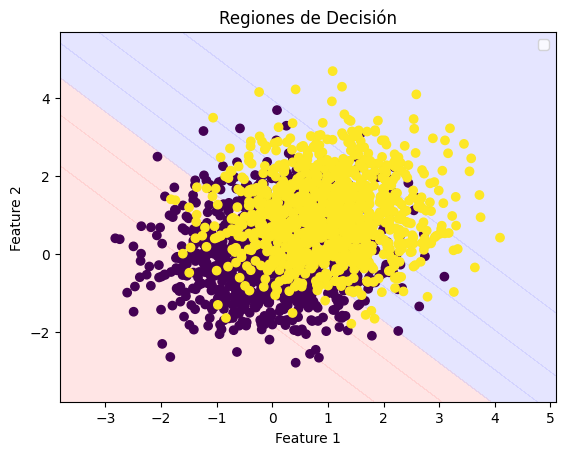

In [ ]:
plt.figure()
cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.3)

plt.scatter(features[:,1],features[:,2], c=labels)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Regiones de Decisión')
plt.legend()
plt.show()
